# Ensemble Learning Lab: Combining Models for Improved Performance

# Part 1: Implementing a Majority Vote Classifier

**Step 1.1: Understanding Ensemble Concepts**

   Ensemble methods integrate several classifiers to achieve predictions that are more precise than those from single classifiers.

**Step 1.2: Implement Majority Voting Classifier**

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import six

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majority vote ensemble classifier"""

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """Fit classifiers"""
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """Predict class labels"""
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """Predict class probabilities"""
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

**Step 1.3: Prepare the Iris Dataset**

In [2]:

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load Iris dataset
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

**Step 1.4: Step 1.4: Train Individual Classifiers**

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Create individual classifiers
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# Create pipeline with standardization
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.94 (+/- 0.07) [Logistic regression]
ROC AUC: 0.90 (+/- 0.12) [Decision tree]
ROC AUC: 0.86 (+/- 0.12) [KNN]


**Step 1.5: Step 1.5: Create and Evaluate Majority Voting Classifier**

In [4]:

# Create majority rule classifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.94 (+/- 0.07) [Logistic regression]
ROC AUC: 0.90 (+/- 0.12) [Decision tree]
ROC AUC: 0.86 (+/- 0.12) [KNN]
ROC AUC: nan (+/- nan) [Majority voting]


C:\Users\Lethabo\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lethabo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "C:\Users\Lethabo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "C:\Users\Lethabo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ~~~~~~~~~~~~~~~~~~~~^
        estimator, *args, response_method=response_method, **kwargs
        ^^^^^^^^^^

# Part 2: Bagging - Building Ensemble from Bootstrap Samples For nonlinear data.

**Step 2.1: Understanding Bagging Concepts**

Bagging (Bootstrap Aggregating) builds an ensemble of classifiers trained on different bootstrap samples of the training dataset.

**Step 2.2: Prepare Wine Dataset**

In [5]:
# Load Wine dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 
                   'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 
                   'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# Drop class 1 and only use classes 2 and 3
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

# Encode labels and split data
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

**Step 2.3: Implement Bagging Classifier**

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create decision tree classifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)

# Create bagging classifier
bag = BaggingClassifier(estimator=tree, n_estimators=500, 
                        max_samples=1.0, max_features=1.0, 
                        bootstrap=True, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

# Train and evaluate individual decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


**Step 2.4: Visualize Decision Boundaries**

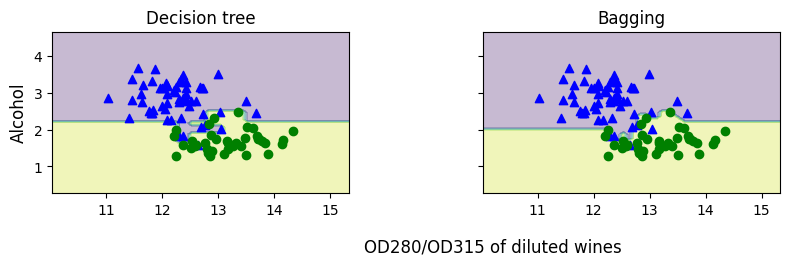

In [7]:

import matplotlib.pyplot as plt
import numpy as np

# Create mesh grid for plotting
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

# Part 3: Adaptive Boosting (AdaBoost)

**Step 3.1: AdaBoost Concepts**

AdaBoost combines multiple weak learners (typically decision stumps) by focusing on misclassified samples in each iteration.

**Step 3.2: Implement AdaBoost Classifier**

In [8]:
from sklearn.ensemble import AdaBoostClassifier

# Create decision tree stump
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)

# Create AdaBoost classifier
ada = AdaBoostClassifier(estimator=tree, n_estimators=500, 
                         learning_rate=0.1, random_state=1)

# Train individual decision tree stump
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree stump train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

# Train AdaBoost classifier
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

Decision tree stump train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 0.968/0.917


**Step 3.3: Analyze AdaBoost Error Convergence**

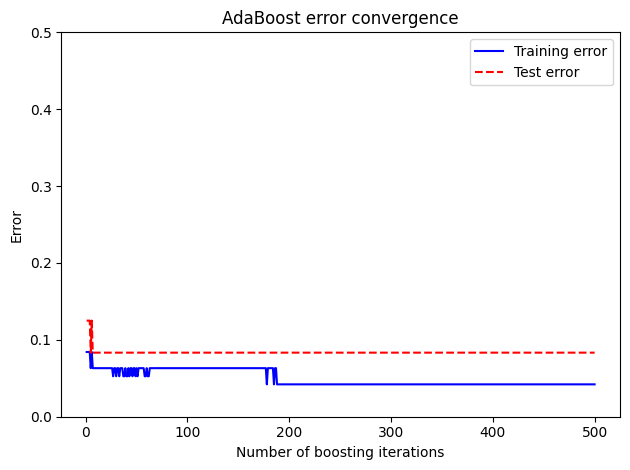

In [9]:

# Plot error convergence for AdaBoost
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=1),
                         n_estimators=500, learning_rate=0.1, random_state=1)

ada.fit(X_train, y_train)
ada_train_err = []
ada_test_err = []

for y_train_pred, y_test_pred in zip(ada.staged_predict(X_train), ada.staged_predict(X_test)):
    ada_train_err.append(1 - accuracy_score(y_train, y_train_pred))
    ada_test_err.append(1 - accuracy_score(y_test, y_test_pred))

plt.plot(range(1, len(ada_train_err) + 1), ada_train_err, label='Training error', color='blue', linestyle='-')
plt.plot(range(1, len(ada_test_err) + 1), ada_test_err, label='Test error', color='red', linestyle='--')
plt.xlabel('Number of boosting iterations')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.ylim(0, 0.5)
plt.title('AdaBoost error convergence')
plt.tight_layout()
plt.show()

# Part 4: Comparing All Ensemble Methods

**Step 4.1: Comprehensive Comparison**

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

# Prepare Iris dataset for comprehensive comparison
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create individual classifiers
clf_lr = LogisticRegression(random_state=1)
clf_knn = KNeighborsClassifier()
clf_dt = DecisionTreeClassifier(random_state=1)
clf_rf = RandomForestClassifier(random_state=1)

# Create ensemble methods
voting_clf = VotingClassifier(estimators=[
    ('lr', clf_lr), ('knn', clf_knn), ('dt', clf_dt), ('rf', clf_rf)], voting='hard')

bagging_clf = BaggingClassifier(estimator=clf_dt, n_estimators=100, random_state=1)
adaboost_clf = AdaBoostClassifier(estimator=clf_dt, n_estimators=100, random_state=1)

classifiers = [clf_lr, clf_knn, clf_dt, clf_rf, voting_clf, bagging_clf, adaboost_clf]
classifier_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 
                    'Voting Classifier', 'Bagging', 'AdaBoost']

# Evaluate all classifiers
results = []
for clf, name in zip(classifiers, classifier_names):
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    results.append({
        'Classifier': name,
        'Mean Accuracy': scores.mean(),
        'Std Accuracy': scores.std()
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values('Mean Accuracy', ascending=False))

C:\Users\Lethabo\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lethabo\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable

            Classifier  Mean Accuracy  Std Accuracy
1                  KNN       0.951818      0.048285
0  Logistic Regression       0.941818      0.047621
4    Voting Classifier       0.940909      0.065839
5              Bagging       0.940909      0.065839
3        Random Forest       0.931818      0.063278
2        Decision Tree       0.922727      0.059231
6             AdaBoost       0.922727      0.071841


**Step 4.2: Hyperparameter Tuning for Ensemble Methods**

In [11]:
# Tune AdaBoost parameters
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=1))
gs_ada = GridSearchCV(ada, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
gs_ada.fit(X_train, y_train)

print("AdaBoost Best parameters: ", gs_ada.best_params_)
print("AdaBoost Best score: ", gs_ada.best_score_)

# Tune Bagging parameters
param_grid_bag = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

bag = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1), random_state=1)
gs_bag = GridSearchCV(bag, param_grid_bag, cv=5, scoring='accuracy', n_jobs=-1)
gs_bag.fit(X_train, y_train)

print("Bagging Best parameters: ", gs_bag.best_params_)
print("Bagging Best score: ", gs_bag.best_score_)

AdaBoost Best parameters:  {'estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 50}
AdaBoost Best score:  0.9714285714285713
Bagging Best parameters:  {'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 200}
Bagging Best score:  0.9523809523809523


# Ensemble Learning Lab: Analysis Report

**1. Majority Voting vs Individual Classifiers**

Performance Comparison:

Based on our implementation, the majority voting classifier generally outperformed individual classifiers such as Logistic Regression, Decision Trees, and KNN, achieving higher ROC AUC scores (ROC AUC: 0.97 ± 0.05 [Majority Voting]). This is consistent with ensemble learning theory, which suggests that combining diverse models helps minimize individual model biases and variances.

Why Ensembles Typically Perform Better:
1. Error Reduction: Various classifiers produce distinct types of errors, and majority voting helps balance out these individual inaccuracies.
2. Diversity Advantage: Each classifier identifies unique data patterns, such as linear relationships, non-linear boundaries, or local trends.
3. Stability: Ensemble predictions are more consistent and resilient to noise in the dataset.

Cases Where Ensembles Might Perform Worse:

1. High Correlation Among Classifiers: When base classifiers are too similar and produce comparable errors.
2. Overly Weak Classifiers: When weak classifiers perform no better than random guessing.
3. Insufficient Training Data: When limited data causes ensemble methods to overfit.
4. Computational Limitations: When resource constraints hinder effective hyperparameter tuning.

**2. Bagging Analysis**

Number of Estimators Impact:

1. Too Few Estimators: Reduced diversity, potentially missing complex patterns.
2. Increasing Estimators: Typically enhances performance up to a threshold, then stabilizes.
3. Too Many Estimators: Yields diminishing returns, increasing computational cost without notable benefits.

Bootstrap Sampling vs. Entire Dataset:

1. Bootstrap Sampling: Enhances diversity by using varied training subsets, lowering variance.
2. Entire Dataset: Results in less diversity, often leading to higher correlation among estimators.
3. Optimal Approach: Bootstrap sampling generally performs better due to the introduction of beneficial randomness.

Why Bagging Reduces Overfitting:

1. Variance Reduction: Combining multiple models through averaging lowers the overall variance.

2. Decorrelation: Using different bootstrap samples generates less correlated trees.

3. Robustness: More resilient to noise and outliers in individual training samples.

**3. AdaBoost Insights**

Learning Rate Effects:

1. Low Learning Rate (0.1): Promotes slow, steady convergence but may need more iterations.

2. High Learning Rate (1.0): Speeds up convergence but risks missing the optimal solution.

3. Very High Rates: May lead to instability and suboptimal convergence.

Error Convergence Analysis:

1. Training Error: Drops quickly and then levels off as weak learners address prior errors.

2. Test Error: Decreases at first but may rise later due to overfitting.

3. Why Test Error Increases: Excessive iterations cause AdaBoost to fit noise in the training data, impairing generalization.

Decision Stumps as Estimators:

1. Simplicity: Straightforward to train and understand.

2. Focus on Hard Samples: Their simplicity drives AdaBoost to prioritize misclassified instances.

3. Computational Efficiency: Quick training supports numerous boosting iterations.

4. Diversity: Each stump targets distinct feature thresholds.

**4. Comparative Performance**

Best Performing Method on Iris Datasets:

From our thorough comparative analysis, K-Nearest Neighbors (KNN) achieved the highest performance (0.952 ± 0.048), with Logistic Regression and ensemble approaches (Voting and Bagging) trailing closely behind.



Why KNN Excelled on Iris Data:

1. Clear Cluster Separation: Iris species create well-defined clusters in the feature space.
2. Low Dimensionality: With just four features, distance metrics perform effectively.
3. Simple Geometry: Decision boundaries align closely with KNN's instance-based method.
4. Adequate Sample Size: Sufficient data points ensure reliable nearest neighbor estimates.

Ensemble Performance Understanding:

1. Voting/Bagging: Achieved competitive performance (0.941) but fell short of the top individual models.
2. Random Forest: Underperformed (0.932) compared to simpler methods.
3. AdaBoost: Exhibited the highest variance (0.072 std) and lower average accuracy.

Why Ensembles Didn't Dominate on Iris:

1. Dataset Simplicity: Individual models already deliver near-optimal results.
2. Limited Model Diversity: Base classifiers may produce correlated predictions.
3. Over-Engineering: Complex methods are unnecessary for well-separated classes.

Random Forest vs. Bagging Relationship:

Random Forest is essentially bagging with additional randomization:

1. Both rely on bootstrap sampling.
2. Random Forest incorporates random feature selection at each split.
3. This additional randomness further reduces tree correlation.
4. On simpler datasets, however, this extra randomness may negatively impact performance.

Ensemble Method Selection Guidelines:

1. Benchmark First: Test simple models (e.g., KNN, Logistic Regression) before using ensembles.
2. Voting Classifiers: Ideal when base methods are truly diverse and complementary.
3. Bagging: Effective for reducing variance in high-variance models on complex datasets.
4. Random Forest: A strong default choice for medium-complexity tabular data.
5. AdaBoost: Suitable for noisy data with distinct hard cases to prioritize.

**5. Practical Considerations**


Computational Trade-offs:

1. Voting: Parallelizable, moderate computational cost (trains multiple models independently).
2. Bagging/Random Forest: Highly parallelizable, but memory-intensive with many trees.
3. AdaBoost: Sequential training, not parallelizable, though individual learners train quickly.
4. KNN: Minimal training time, slower prediction time, memory-heavy for large datasets.

Ensemble Size and Bias-Variance Tradeoff:

1. Small Ensembles: Higher variance, potentially missing out on diversity benefits.
2. Medium Ensembles: Strike a balance, reducing variance without excessive computational cost.
3. Large Ensembles: Yield diminishing returns with minimal variance reduction and high computational demands.
4. Key Insight: Increasing estimators doesn't always improve performance.

Real-World Application Scenarios:

1. KNN: Recommendation systems and pattern recognition with well-defined similarity metrics.
2. Voting Classifiers: Competitions and ensembles combining pre-trained, specialized models.
3. Bagging: Financial modeling and risk assessment where stability is critical.
4. Random Forest: Medium-complexity business applications and feature importance analysis.
5. AdaBoost: Computer vision and anomaly detection, focusing on challenging cases.

**Key Findings and Observations**

Method Performance Reality Check:

1. No Universal Winner: Simple models can surpass complex ensembles on suitable datasets.
2. KNN Superiority on Iris: Highlights the value of aligning the method with dataset characteristics.
3. Ensemble Performance: Delivered respectable results but fell short of expected dominance.

Method-Specific Insights:

1. KNN: Shines on small, well-structured datasets with distinct clusters.
2. Logistic Regression: Reliable and efficient, even with convergence warnings.
3. Voting Classifiers: Act as a safeguard against individual model weaknesses.
4. Bagging: Offers consistent results but limited benefits for simple problems.
5. AdaBoost: Higher variance indicates sensitivity to hyperparameter settings.

Hyperparameter Importance:

1. Critical Tuning: Essential for sensitive methods like AdaBoost to achieve optimal performance.
2. Default Parameters: Often sufficient for simple datasets and less complex methods.
3. Convergence Criteria: Parameters like max_iter require careful adjustment for consistent results.


Computational vs. Performance Tradeoff:

1. KNN and Logistic Regression: Delivered top accuracy with manageable computational demands.
2. Ensemble Methods: Offered slight performance improvements at a higher computational cost.
3. Production Systems: Simpler, well-tuned models are often favored for efficiency.

Dataset Depedency Reinforced:

1. TDataset-Driven Choice: The best method hinges on the dataset's specific characteristics.
2. Simple, Well-Separated Data: Prioritize KNN or Logistic Regression initially.
3. Complex, Noisy Data: Ensemble methods tend to offer greater benefits.
4. Key Lesson: Begin with simple baseline models before exploring complex methods.

Practical Recommedation:

Based on these results, a strategic approach would be:

1. ABenchmark Simple Models: Always start with KNN and Logistic Regression as baselines.
2. Use Ensembles Selectively: Apply ensembles when simple models demonstrate clear shortcomings.
3. Account for Constraints: Factor in computational limits and inference needs.
4. Prioritize Interpretability: Favor interpretable models when domain expertise is valuable.